<a href="https://colab.research.google.com/github/DevBatra05/DeepLearningLab/blob/main/Lab_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Probabilistic Image Generation with Variational Autoencoders (VAEs)


In [1]:
!pip install -q kagglehub

import os
import numpy as np
import matplotlib.pyplot as plt
import kagglehub
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [2]:
path = kagglehub.dataset_download("l3llff/flowers")
print("Dataset root:", path)

IMAGE_ROOT = os.path.join(path, "flowers")
print("Images folder:", IMAGE_ROOT)
print("Class folders:", os.listdir(IMAGE_ROOT))


100%|██████████| 228M/228M [00:11<00:00, 21.0MB/s]

Extracting files...


Dataset root: /root/.cache/kagglehub/datasets/l3llff/flowers/versions/4
Images folder: /root/.cache/kagglehub/datasets/l3llff/flowers/versions/4/flowers
Class folders: ['california_poppy', 'black_eyed_susan', 'carnation', 'daffodil', 'bellflower', 'tulip', 'astilbe', 'magnolia', 'calendula', 'rose', 'common_daisy', 'sunflower', 'dandelion', 'coreopsis', 'water_lily', 'iris']


In [3]:
IMG_SIZE   = 64
BATCH_SIZE = 64
AUTOTUNE   = tf.data.AUTOTUNE

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    IMAGE_ROOT,
    seed=42,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='int',          # keep integer labels
    validation_split=0.2,
    subset='training'
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    IMAGE_ROOT,
    seed=42,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='int',
    validation_split=0.2,
    subset='validation'
)

class_names = train_ds.class_names
print("Classes:", class_names)
num_classes = len(class_names)


Found 15740 files belonging to 16 classes.
Using 12592 files for training.
Found 15740 files belonging to 16 classes.
Using 3148 files for validation.
Classes: ['astilbe', 'bellflower', 'black_eyed_susan', 'calendula', 'california_poppy', 'carnation', 'common_daisy', 'coreopsis', 'daffodil', 'dandelion', 'iris', 'magnolia', 'rose', 'sunflower', 'tulip', 'water_lily']


In [4]:
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_ds = train_ds.map(preprocess).cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds   = val_ds.map(preprocess).cache().prefetch(AUTOTUNE)


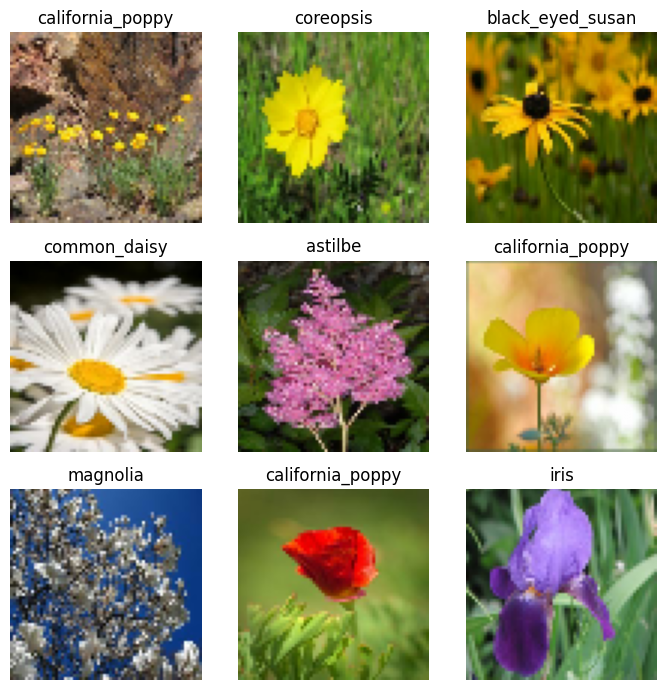

In [5]:
images, labels = next(iter(train_ds))
plt.figure(figsize=(7,7))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i])
    plt.title(class_names[labels[i]])
    plt.axis("off")
plt.tight_layout()
plt.show()


In [6]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [7]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)

z_mean    = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z         = Sampling()([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 16, 16,    │     18,496 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 8, 8, 128) │     73,856 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 8192)      │          0 │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │  1,048,704 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │        258 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │        258 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,142,468 (4.36 MB)

 Trainable params: 1,142,468 (4.36 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
decoder_inputs = keras.Input(shape=(latent_dim,))

x = layers.Dense((IMG_SIZE // 8) * (IMG_SIZE // 8) * 128, activation="relu")(decoder_inputs)
x = layers.Reshape((IMG_SIZE // 8, IMG_SIZE // 8, 128))(x)

x = layers.Conv2DTranspose(128, 3, strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(64, 3, strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, 3, strides=2, activation="relu", padding="same")(x)

decoder_outputs = layers.Conv2D(3, 3, activation="sigmoid", padding="same")(x)

decoder = keras.Model(decoder_inputs, decoder_outputs, name="decoder")
decoder.summary()


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8192)           │        24,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 128)    │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 3)      │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 265,283 (1.01 MB)

 Trainable params: 265,283 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, beta=1.0, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta    # weight for KL term

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.recon_loss_tracker = keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker    = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker,
                self.recon_loss_tracker,
                self.kl_loss_tracker]

    def train_step(self, data):
        # data = (images, labels) but we only use images
        x, _ = data

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(x)
            x_recon = self.decoder(z)

            # ----- reconstruction loss (MSE per pixel) -----
            recon_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.math.squared_difference(x, x_recon), axis=(1, 2, 3)
                )
            )

            # ----- KL divergence loss -----
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(
                    1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var),
                    axis=1
                )
            )

            total_loss = recon_loss + self.beta * kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "recon_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        x, _ = data
        z_mean, z_log_var, z = self.encoder(x)
        x_recon = self.decoder(z)

        # same losses as in train_step
        recon_loss = tf.reduce_mean(
            tf.reduce_sum(
                tf.math.squared_difference(x, x_recon), axis=(1, 2, 3)
            )
        )

        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var),
                axis=1
            )
        )

        total_loss = recon_loss + self.beta * kl_loss

        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "recon_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


In [15]:
vae = VAE(encoder, decoder, beta=1.0)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3))

EPOCHS = 10
history = vae.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)


Epoch 1/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 216s 1s/step - kl_loss: 7.6799 - loss: 781.9924 - recon_loss: 774.3125 - val_kl_loss: 7.2982 - val_loss: 618.2363 - val_recon_loss: 610.9381
Epoch 2/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 211s 1s/step - kl_loss: 7.3511 - loss: 593.3399 - recon_loss: 585.9888 - val_kl_loss: 7.3426 - val_loss: 569.4689 - val_recon_loss: 562.1263
Epoch 3/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 212s 1s/step - kl_loss: 6.9106 - loss: 565.7641 - recon_loss: 558.8537 - val_kl_loss: 6.6625 - val_loss: 558.6198 - val_recon_loss: 551.9573
Epoch 4/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 209s 1s/step - kl_loss: 6.7448 - loss: 559.5090 - recon_loss: 552.7643 - val_kl_loss: 6.4864 - val_loss: 557.0982 - val_recon_loss: 550.6117
Epoch 5/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 262s 1s/step - kl_loss: 6.5567 - loss: 561.3920 - recon_loss: 554.8353 - val_kl_loss: 6.6769 - val_loss: 553.7024 - val_recon_loss: 547.0256
Epoch 6/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 209s 1s/step - kl_loss: 6.5862 - loss: 556.4435 - recon

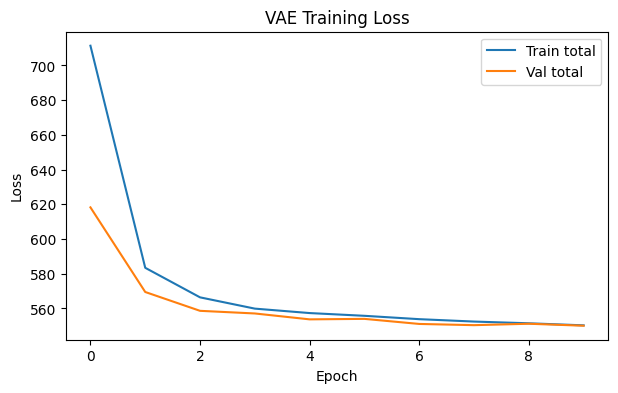

In [16]:
plt.figure(figsize=(7,4))
plt.plot(history.history["loss"], label="Train total")
plt.plot(history.history["val_loss"], label="Val total")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("VAE Training Loss")
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


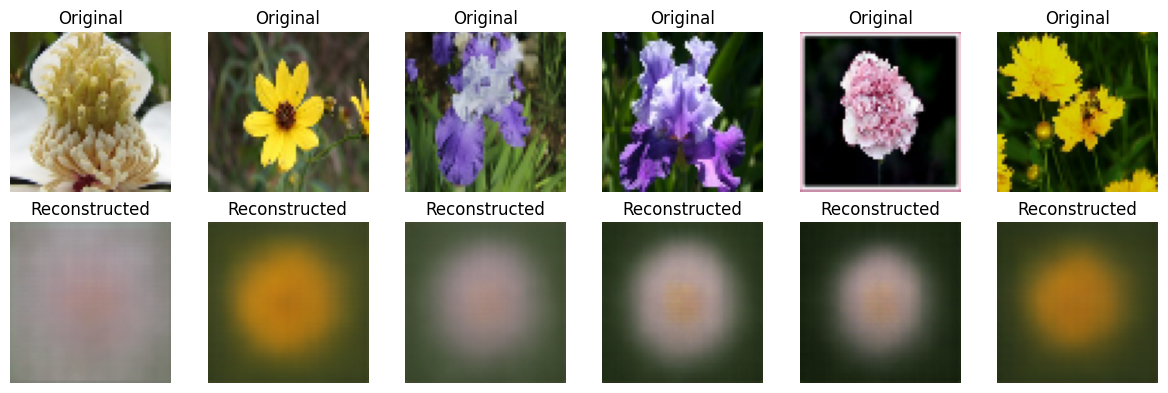

In [17]:
# take one validation batch
x_batch, _ = next(iter(val_ds))
z_mean, z_log_var, z = encoder.predict(x_batch)
x_recon = decoder.predict(z)

n = 6
plt.figure(figsize=(12,4))
for i in range(n):
    # original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_batch[i])
    ax.set_title("Original")
    plt.axis("off")

    # reconstructed
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(x_recon[i])
    ax.set_title("Reconstructed")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [18]:
all_z = []
all_labels = []

for images, labels in val_ds:
    z_mean, _, _ = encoder.predict(images)
    all_z.append(z_mean)
    all_labels.append(labels.numpy())

all_z = np.concatenate(all_z, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

print("Latent shape:", all_z.shape)   # (N, 2)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━

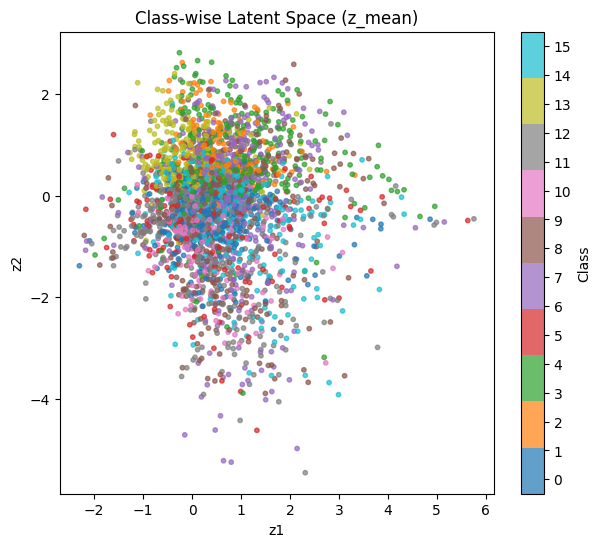

In [19]:
plt.figure(figsize=(7,6))
scatter = plt.scatter(all_z[:,0], all_z[:,1],
                      c=all_labels, cmap="tab10", alpha=0.7, s=10)
plt.colorbar(scatter, ticks=range(num_classes), label="Class")
plt.clim(-0.5, num_classes-0.5)
plt.title("Class-wise Latent Space (z_mean)")
plt.xlabel("z1")
plt.ylabel("z2")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


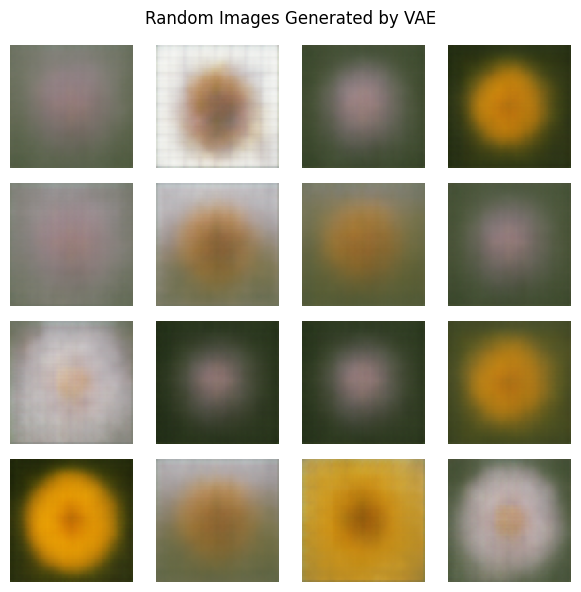

In [22]:
# sample random points in latent space
num_samples = 16
random_z = np.random.normal(size=(num_samples, latent_dim))
generated = decoder.predict(random_z)

plt.figure(figsize=(6,6))
for i in range(num_samples):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(generated[i])
    plt.axis("off")
plt.suptitle("Random Images Generated by VAE")
plt.tight_layout()
plt.show()
